In [4]:
import numpy as np
import pandas as pd
import zipfile         
import os
import matplotlib.pyplot as plt
import altair as alt
import seaborn as sns 
import DateTime
import re 
import cpi
import warnings
warnings.filterwarnings('ignore')

#pd.set_option('display.max_columns', 100)
pd.options.display.float_format = '{:.2f}'.format
pd.set_option("display.max_columns", 330)

#### Load in PUMS household Data

got data below from downloading these zips like below
for i in range_list:
    print("https://www2.census.gov/programs-surveys/acs/data/pums/"+i+"/1-Year/csv_hca.zip")

In [5]:
#PUMA - County Crosswalk - https://mcdc.missouri.edu/applications/geocorr2018.html.
#note, manually changed all one to many (PUMA->County) matchings to just be "Multiple CA".
#These are the small counties that are just a part of a PUMA and for the purpose of our analysis are combined 
crosswalk_df=pd.read_csv("/Users/quinnunderriner/Desktop/Work/missing_middle/PUMA_County_Crosswalk_v2 - PUMA_County_Crosswalk.csv", delimiter=",")

In [6]:
def read_in_PUMS(hpums_df):
    variable_types = {"NP":"int64","NOC":"float","BDSP":"float","RMSP":"str","MV":"float","WGTP":"float"}

    columns = ["SERIALNO","NP","R65","NRC","PUMA","RT","BDSP","BLD","RNTP","MRGP","SMP", "TYPE",
               "CONP","TEN","VACS","VALP","GRPIP","GRNTP","SMOCP","OCPIP","HINCP","MV","WGTP","NOC", "MULTG", 'YBL']


    hpums_df.rename(columns={"RT":"record_type",
                         "TYPE":"type",
                         "BLD":"units_in_structure",
                         "BDSP":"number_bedrooms",
                         "RNTP":"monthly_rent",
                         "MRGP":"first_mortgage",
                         "SMP":"second_mortgage",
                         "CONP":"condo_fee",
                         "TEN":"tenure",
                         "VACS":"vacancy_status",
                         "VALP":"property_value",
                         "GRPIP":"gross_rent_pct_of_income",
                         "GRNTP":"gross_rent",
                         "SMOCP":"select_owner_cost",
                         "OCPIP":"select_owner_cost_pct_of_income",
                         "HINCP":"hh_income",
                         "NP":"ppl_in_hh",
                         "R65":"ppl_over_65",
                         "NRC":"num_relate_chldrn",
                         "NOC":"num_own_chldrn",
                         "MULTG":"multi_gen_hh",
                         "WGTP":"weight",
                         "YBL": "year_built",
                         "MV":"moved_in"}, inplace=True)
    hpums_df.drop(hpums_df[hpums_df.type != 1].index, inplace=True)
    
    return hpums_df

In [7]:
#pums2.to_csv("2010-2019_ca_household_survey_v2.csv")

Put this code in this cell because I want to be rerunning file and easier to just load in output of below from a csv then wait for the below to run to run everytime. But this code takes the 2010-2019 PUMS household data, makes a year column, and then concat its together 

for filename in os.listdir(path_csv):
    df_new1 = pd.read_csv(os.path.join(path_csv, filename))
    df_new1= read_in_PUMS(df_new1,col_names)
    df_new1["year"] = filename[-8:-4] 
    hca = pd.concat([hca,df_new1],ignore_index=True)
pums_ca = hca.ST["6"]#added retroactively 

In [8]:
#load in output of above from CSV 
pums_ca_raw = pd.read_csv("/Users/quinnunderriner/Desktop/Work/missing_middle/2010-2019_ca_household_survey_v2.csv")
pums_sub_cols = ['year',"hh_income","ppl_in_hh",'PUMA',"gross_rent"]#Took more cols just in case from big dataset above, but this is all we need for this calc #took county col out here to recreate later 
pums_ca_raw = pums_ca_raw[pums_sub_cols]

### Do PUMA to County Crosswalk

Note: for years 2010 and 2011 the 2010 PUMA defintions were still being used; it was not until 2012 that the
    new definitions came into effect. Therefore need to map the 2010-2011 and 2012-2019 groups seperately. 

merge other crosswalk file on here and drop PUMA10_Name
then drop duplicates 
should preprocess this to be just mapping of puma00 to unique county 

analysitics gut check, are top 10 counties the correct top 10 counties 

In [9]:
def map2counties(pums_ca):
    crosswalk_df2010 = pd.read_excel("PUMA2000_PUMA2010_crosswalk.xls") # https://usa.ipums.org/usa/volii/pumas10.shtml#crosswalk
    crosswalk_df2010 = crosswalk_df2010[crosswalk_df2010.State10_Name =="California"]
    crosswalk_df2010 = crosswalk_df2010[["PUMA00","PUMA10","PUMA10_Name"]] 
    crosswalk_df2012 = pd.read_csv("/Users/quinnunderriner/Desktop/Work/missing_middle/PUMA_County_Crosswalk_v2 - PUMA_County_Crosswalk.csv", delimiter=",")
    crosswalk_df2010 = crosswalk_df2010.merge(crosswalk_df2012,left_on="PUMA10",right_on="PUMA", how='left')#[["PUMA00","county1"]]
    crosswalk_df2010 = crosswalk_df2010.drop_duplicates(subset=["PUMA00"])
    
    df_2010 = pums_ca[pums_ca.year.isin([2010,2011])] 
    df_2010 = pd.merge(df_2010, crosswalk_df2010, left_on='PUMA', right_on='PUMA00', how='left')
    
    df_2012 = pums_ca[~pums_ca.year.isin([2010,2011])]
    df_2012 = pd.merge(df_2012, crosswalk_df2012, on='PUMA', how='left')
    
    df = df_2010.append(df_2012)
    df['County'] = df['county1'].str.replace(r' CA', '')
    df.loc[df.PUMA_x.notnull(), 'PUMA'] = df.loc[df.PUMA_x.notnull(), 'PUMA_x'] 
    return df[['year', 'hh_income', 'ppl_in_hh', 'gross_rent', 'PUMA', 'County']]
    

In [10]:
pums_ca = map2counties(pums_ca_raw)

In [11]:
#missing shasta and modera in 2010-2011, they are now mapped to multiple, this is a quirk of the mappings change and they are not in top 10 msa so its fine 
pums_ca.groupby(["year","County"]).count().reset_index().groupby("year").count()

,County,hh_income,ppl_in_hh,gross_rent,PUMA
year,,,,,
2010,34,34,34,34,34
2011,34,34,34,34,34
2012,36,36,36,36,36
2013,36,36,36,36,36
2014,36,36,36,36,36
2015,36,36,36,36,36
2016,36,36,36,36,36
2017,36,36,36,36,36
2018,36,36,36,36,36


In [12]:
pums_ca = pums_ca[(pums_ca.hh_income != ' ')] # we lose ~8k records for missing data
pums_ca['hh_income'] = pums_ca.hh_income.astype(float)
pums_ca['ppl_in_hh'] = pums_ca.ppl_in_hh.astype(float)

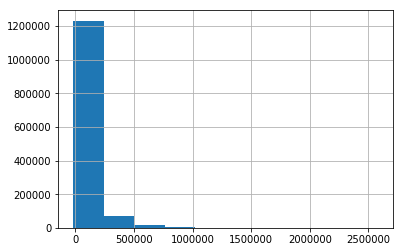

In [13]:
import matplotlib.pyplot as plt
#check for outliers in hh income 
pums_ca.hh_income.hist()

In [14]:
#in this dataset negative income doenst really make sense, so I'll drop those rows.
#Strange to see renter with 2.5 million income, but certainly not impossible in california so can't
#assume data error. 
pums_ca.hh_income.describe()

count   1316531.00
mean      95826.00
std      104647.27
min      -15700.00
25%       32300.00
50%       67000.00
75%      120500.00
max     2580000.00
Name: hh_income, dtype: float64

In [15]:
pums_ca = pums_ca[pums_ca['hh_income'] >=0] #drop negative hh income  

In [16]:
pums_ca.County = pums_ca.County.str.rstrip()#strip trailing white space 
pums_ca = pums_ca.replace({
    'County':{'Monterey (South & East) & San Benito Countie':"Multiple",
            'Nevada & Sierra Countie':"Multiple","Sutter & Yuba Counties--Yuba Cit":"Multiple",
            "Del Norte, Lassen, Modoc, Plumas & Siskiyou Countie":"Multiple",
            "Alpine, Amador, Calaveras, Inyo, Mariposa, Mono & Tuolumne Countie":"Multiple",
             'Colusa, Glenn, Tehama & Trinity Countie':"Multiple",
             "Lake & Mendocino Countie":"Multiple"}})#the 2010-2011 data did the one to many PUMA to County mapping, I'm just manually setting these to the Multiple category

There is going to be a discrepency between the HUD data, which has every county in California, 
with the PUMS data, which has only the those that have a least one PUMA soley mapped to it. 
We need then to map the small counties in HUD with a one PUMA to many counties matching to the 
"multiple counties" category that we have in the PUMS data. 

### Merge HUD and PUMS data 

In [17]:
# read in HUD AMI data downloaded for each year from here https://www.huduser.gov/portal/datasets/il.html#2010
path = "/Users/quinnunderriner/Desktop/Work/missing_middle/county_median_data/"
#path = os.getcwd()
df = pd.DataFrame()
for filename in os.listdir(path):
    if filename.startswith("HUD-IL"):
        df_new = pd.read_csv(os.path.join(path, filename))
        df_new["year"] = filename[-8:-4]
        median_col = [x for x in df_new.columns if "median" in x]

        df_new = df_new.rename(columns={median_col[0]:"median"})

        columns = ["State_Alpha","County_Name","Metro_Area_Name","year","median"]
        df_new = df_new[columns]
        df = pd.concat([df,df_new],ignore_index=True)
df = df[df.State_Alpha =="CA"]#filter for california
#df.to_csv("california_hud_AMI_levels_2010-2019.csv")

In [18]:
#df is loaded at top of notebook, is HUD data 
#make sets of both county lists and look at the set difference to see what needs the "multiple" mapping 
pums_ca['County_Name'] = pums_ca.County + " County"#make naming conventions align with HUD data so can merge

pums_set = set(pums_ca.County_Name)
hud_set = set(df["County_Name"])#now want to map everything not present in this data to the multiple category 
small_counties = hud_set.difference(pums_set) #using set difference easily allows us to see what is in HUD but not in PUMS

In [19]:
def small_multiples(x):
    """
    This function returns "Multiple Counties" if county name is in the list of small counties, otherwise
    keeps same value 
    """
    if x in small_counties:
        return "Multiple County"
    else:
        return x 
df["County_Name"] = df["County_Name"].apply(lambda x: small_multiples(x))

df.year = df.year.astype(int)#to be able to merge 
df.loc[df.County_Name=='Multiple County', 'Metro_Area_Name'] = 'Multiple'

df = df.groupby(['year', 'County_Name', 'Metro_Area_Name'])['median'].median().reset_index() # take median of multiple counties

In [20]:
#merge data 
df_merged = pums_ca.merge(df,on=["County_Name","year"],how="left")
#df_merged.to_csv("HUD_PUMS_merged_data_CA.csv")

In [21]:
df_merged.groupby('year').count()

,hh_income,ppl_in_hh,gross_rent,PUMA,County,County_Name,Metro_Area_Name,median
year,,,,,,,,
2010,128552,128552,48131,128552,128552,128552,128552,128552
2011,128957,128957,48907,128957,128957,128957,128957,128957
2012,129197,129197,49844,129197,129197,129197,129197,129197
2013,130078,130078,50354,130078,130078,130078,130078,130078
2014,131060,131060,131060,131060,131060,131060,131060,131060
2015,132140,132140,51036,132140,132140,132140,132140,132140
2016,132754,132754,50927,132754,132754,132754,132754,132754
2017,133375,133375,50837,133375,133375,133375,133375,133375
2018,134192,134192,50884,134192,134192,134192,134192,134192


Need to adjust median income figure for family size 

"Calculation of income limits for other family sizes is straight-forward. The 1-person family income limit is 70% of the 4-person income limit. The 2-person family income limit is 80% of the 4-person income limit, the 3-person family income limit is 90% of the 4-person income limit, the 5-person income limit is 108% of the 4-person income limit, the 6-person family income limit is 116% of the 4-person income limit, the 7-person family income limit is 124% of the 4-person income limit, and the 8-person family income limit is 132% of the 4-person income limit. For family sizes larger than 8 persons, the income limit can be calculated by adding an additional eight (8) percent per person to the next lower limit. For example a 9-person family income limit is 140% (132% + 8%), and so on. The resulting low-income limit calculation for other family sizes are then rounded up to the nearest $50 to produce the Final VLIL."

https://www.huduser.gov/portal/datasets/il/il2020/2020IlCalc.odn


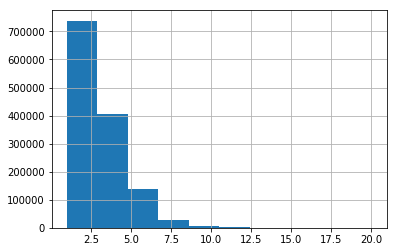

In [22]:
#need to have household adjustments for up to size 20 
df_merged.ppl_in_hh.hist()

### Create AMI bands and normalize by family size 

In [23]:
family_size_dict = {1:.7,
                   2:.8,
                   3:.9,
                   4:1,
                    5:1.08,
                    6:1.16,
                    7:1.24,
                    8:1.32,
                   9:1.40,
                   10:1.48,
                   11:1.56,
                   12:1.64,
                   13:1.72,
                   14:1.80,
                   15:1.88,
                   16:1.96,
                   17:2.04,
                   18:2.12,
                   19:2.20,
                   20:2.28}
#make new column of the AMI multiplier based on each households family size 
df_merged["family_size_multiplier"] = df_merged["ppl_in_hh"].map(family_size_dict)

In [24]:
#create AMI percentages from median numbers and adjust for size of each household 
df_merged["80%_AMI"] = df_merged["median"] * 0.8
df_merged["120%_AMI"] = df_merged["median"] * 1.2
#adjust ami bands for each household based on household size 
df_merged["80%_AMI_adjusted"] = df_merged["80%_AMI"] * df_merged["family_size_multiplier"]
df_merged["120%_AMI_adjusted"] = df_merged["120%_AMI"] * df_merged["family_size_multiplier"]

df_merged["30%_AMI"] = df_merged["median"] * 0.3
df_merged["30%_AMI_adjusted"] = df_merged["30%_AMI"] * df_merged["family_size_multiplier"]

df_merged["60%_AMI"] = df_merged["median"] * 0.6
df_merged["60%_AMI_adjusted"] = df_merged["60%_AMI"] * df_merged["family_size_multiplier"]

df_merged["100%_AMI_adjusted"] = df_merged["median"] * df_merged["family_size_multiplier"]

In [25]:
#want to create binary varables for all of the income groups 
df_merged['0-30%AMI_HH_adj'] = np.where((df_merged["hh_income"] < df_merged["30%_AMI_adjusted"]), 1, 0)

#can add 30-60 even if not on sheet 
df_merged['30-60%AMI_HH_adj'] = np.where((df_merged["hh_income"] >= df_merged["30%_AMI_adjusted"])&(df_merged["hh_income"] < df_merged["60%_AMI_adjusted"]), 1, 0)

df_merged['60-80%_AMI_HH_adj'] = np.where((df_merged["hh_income"] >= df_merged["60%_AMI_adjusted"])&(df_merged["hh_income"] < df_merged["80%_AMI_adjusted"]), 1, 0)

df_merged['80-100%_AMI_HH_adj'] = np.where((df_merged["hh_income"] >= df_merged["80%_AMI_adjusted"])&(df_merged["hh_income"] < df_merged["100%_AMI_adjusted"]), 1, 0)

df_merged['100-120%_AMI_HH_adj'] = np.where((df_merged["hh_income"] >= df_merged["100%_AMI_adjusted"])&(df_merged["hh_income"] < df_merged["120%_AMI_adjusted"]), 1, 0)

df_merged['120%+_AMI_HH_adj'] = np.where((df_merged["hh_income"] >= df_merged["120%_AMI_adjusted"]), 1, 0)



#want to label households in dataset that are middle income 
df_merged['middle_income_HH_adj'] = np.where((df_merged["hh_income"] >= df_merged["80%_AMI_adjusted"])&(df_merged["hh_income"] <= df_merged["120%_AMI_adjusted"]), 1, 0)

In [26]:
#want to create binary varables for all of the income groups 
df_merged['0-30%AMI_HH'] = np.where((df_merged["hh_income"] < df_merged["30%_AMI"]), 1, 0)

#can add 30-60 even if not on sheet 
df_merged['30-60%AMI_HH'] = np.where((df_merged["hh_income"] >= df_merged["30%_AMI"])&(df_merged["hh_income"] < df_merged["60%_AMI"]), 1, 0)

df_merged['60-80%_AMI_HH'] = np.where((df_merged["hh_income"] >= df_merged["60%_AMI"])&(df_merged["hh_income"] < df_merged["80%_AMI"]), 1, 0)

df_merged['80-100%_AMI_HH'] = np.where((df_merged["hh_income"] >= df_merged["80%_AMI"])&(df_merged["hh_income"] < df_merged["median"]), 1, 0)

df_merged['100-120%_AMI_HH'] = np.where((df_merged["hh_income"] >= df_merged["median"])&(df_merged["hh_income"] < df_merged["120%_AMI"]), 1, 0)

df_merged['120%+_AMI_HH'] = np.where((df_merged["hh_income"] >= df_merged["120%_AMI"]), 1, 0)



#want to label households in dataset that are middle income 
df_merged['middle_income_HH'] = np.where((df_merged["hh_income"] >= df_merged["80%_AMI"])&(df_merged["hh_income"] <= df_merged["120%_AMI"]), 1, 0)

In [27]:
middle_income = df_merged[df_merged['middle_income_HH'] ==1]
middle_income_adj = df_merged[df_merged['middle_income_HH_adj'] ==1]

In [28]:
# 17.3 percent of households in our dataset fall into this middle income category
len(middle_income_adj)/len(df_merged) 

0.17351203956748146

In [29]:
#want to melt dataset to be able to make charts from it 
df_melt = df_merged[['Metro_Area_Name',"County_Name","year",'0-30%AMI_HH', '30-60%AMI_HH', '60-80%_AMI_HH', '80-100%_AMI_HH',
       '100-120%_AMI_HH', '120%+_AMI_HH']].groupby(['Metro_Area_Name',"County_Name","year"]).sum()
df_melt = df_melt.reset_index().melt(["County_Name","year",'Metro_Area_Name'])
df_melt = df_melt.rename(columns={"year":"Year","variable":"AMI_Band","value":"Number of Renter Households"}) 

In [30]:
#need to add total county by year and county so can make each AMI band number a percentage of total 
melted_total_year_county = df_melt.groupby(["Year","County_Name"]).sum().reset_index()
#rename to reflect true value 
melted_total_year_county = melted_total_year_county.rename(columns ={"Number of Renter Households":"Total Number of Households"})
#merge on to df_melt
df_melt = df_melt.merge(melted_total_year_county,how="left",on=["County_Name","Year"])
#make new column with percentages 
df_melt["Percentage of Households"] = df_melt["Number of Renter Households"] / df_melt["Total Number of Households"]

#now need to sort by correct value of AMI-Band for the legend so that it displays in order 
AMI_order = pd.Categorical([ '0-30%AMI_HH', '30-60%AMI_HH', '60-80%_AMI_HH', '80-100%_AMI_HH',
       '100-120%_AMI_HH', '120%+_AMI_HH'],ordered=True) 
df_melt = df_melt.sort_index(level=AMI_order)

In [35]:
#create hh income groupings 
def hh_income_groups(x):
    if x < 30000:
        return '<30'
    elif x >= 30000 and x < 60000:
        return '30-60'
    elif x>= 60000 and x<80000:
        return '60-80'
    elif x >= 80000 and x<100000:
        return '80-100'
    else:
        return ">100"
#for general trends, done again below with all the final groupings 
def ami_bracket(x, lower, upper):
    if x < lower:
        return '<80%'
    elif x >= lower and x < upper:
        return '80%-120%'
    else:
        return '>120%'

In [36]:
# all of CA
df_ca = df_melt.groupby(['Year', 'AMI_Band']).sum().reset_index()

# recompute %
df_ca['Percentage of Households'] = df_ca['Number of Renter Households']/df_ca['Total Number of Households']

#now need to sort by correct value of AMI-Band for the legend so that it displays in order 
df_ca["AMI_Bands"] = pd.Categorical(df_ca["AMI_Band"],[ '0-30%AMI_HH', '30-60%AMI_HH', '60-80%_AMI_HH', '80-100%_AMI_HH',
       '100-120%_AMI_HH', '120%+_AMI_HH'],ordered=True) 
df_ca = df_ca.sort_values("AMI_Bands")

### Graph AMI band data 

Text(0.5, 1.0, 'Percentage of Renter Households in Each AMI Band (All California)')

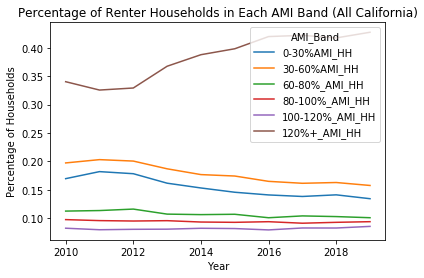

In [37]:
sns.lineplot(data=df_ca, x="Year", y="Percentage of Households", hue="AMI_Band",ci=None).set_title('Percentage of Renter Households in Each AMI Band (All California)')

In [38]:
# top 10 metros

#pull in mapping of MSAs to Counties from here https://catalog.data.gov/dataset/california-metropolitan-statistical-areas-msa-and-metropolitan-divisions-md-163d2/resource/580630a6-9db5-4aaf-b331-3a4b3d476c09
#get ranking of MSAs here: https://docs.fcc.gov/public/attachments/DOC-240702A2.pdf
#
msa = pd.read_csv("msa.csv")
msa = msa[["MSA_NAME","COUNTIES"]]
top_10_msa = ['Riverside-San Bernardino-Ontario','San Jose-Sunnyvale-Santa Clara',
              'San Francisco-Redwood City-South San Francisco','Oakland-Hayward-Berkeley',
              'Los Angeles-Long Beach-Glendale','Anaheim-Santa Ana-Irvine','San Diego-Carlsbad',
               'Sacramento--Roseville--Arden-Arcade','Fresno','Oxnard-Thousand Oaks-Ventura']
msa = msa[msa.MSA_NAME.isin(top_10_msa)]
#need to expand mapping 
msa = msa.drop('COUNTIES', axis=1).join(
  msa['COUNTIES'].str.split(',', expand=True).stack()
    .reset_index(level=1,drop=True).rename('COUNTIES'))
msa['COUNTIES'] = msa['COUNTIES'] + " County" 
msa = msa.rename(columns={"COUNTIES":"County_Name"})#rename for clean merge 

In [39]:
df_top10 = pd.merge(df_melt, msa, on='County_Name')
df_top10 = df_top10.groupby(['Year', 'AMI_Band']).sum().reset_index()

In [40]:
df_top10['Percentage of Households'] = df_top10['Number of Renter Households']/df_top10['Total Number of Households']

In [41]:
#now need to sort by correct value of AMI-Band for the legend so that it displays in order 
df_top10["AMI_Bands"] = pd.Categorical(df_top10["AMI_Band"],[ '0-30%AMI_HH', '30-60%AMI_HH', '60-80%_AMI_HH', '80-100%_AMI_HH',
       '100-120%_AMI_HH', '120%+_AMI_HH'],ordered=True) 
df_top10 = df_top10.sort_values("AMI_Bands")

df_top10.head()

,Year,AMI_Band,Number of Renter Households,Total Number of Households,Percentage of Households,AMI_Bands
0,2010,0-30%AMI_HH,14986,86995,0.17,0-30%AMI_HH
30,2015,0-30%AMI_HH,12639,86450,0.15,0-30%AMI_HH
54,2019,0-30%AMI_HH,12159,89245,0.14,0-30%AMI_HH
36,2016,0-30%AMI_HH,12404,86980,0.14,0-30%AMI_HH
6,2011,0-30%AMI_HH,16159,88764,0.18,0-30%AMI_HH


Text(0.5, 1.0, 'Percentage of Renter Households in Each AMI Band (10 Largest MSAs in California)')

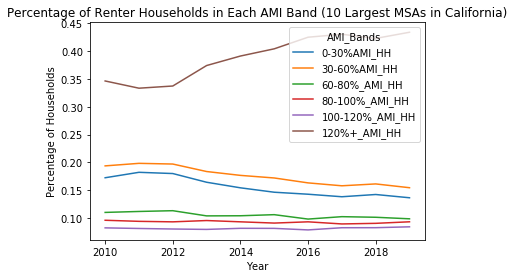

In [42]:
sns.lineplot(data=df_top10, x="Year", y="Percentage of Households", hue="AMI_Bands",ci=None).set_title('Percentage of Renter Households in Each AMI Band (10 Largest MSAs in California)')

### Graph AMI bands for a few more counties - ultimately do all 

In [43]:
def make_county_chart(df_melt,county_name):
    df_melt_new_county = df_melt[df_melt.County_Name == county_name]
    
    df_melt_new_county = df_melt_new_county.groupby(['Year', 'AMI_Band']).sum().reset_index()
    # recompute %
    df_melt_new_county['Percentage of Households'] = df_melt_new_county['Number of Renter Households']/df_melt_new_county['Total Number of Households']

    #now need to sort by correct value of AMI-Band for the legend so that it displays in order 
    df_melt_new_county["AMI_Bands"] = pd.Categorical(df_melt_new_county["AMI_Band"],[ '0-30%AMI_HH', '30-60%AMI_HH', '60-80%_AMI_HH', '80-100%_AMI_HH',
           '100-120%_AMI_HH', '120%+_AMI_HH'],ordered=True) 
    df_melt_new_county = df_melt_new_county.sort_values("AMI_Bands")
    return df_melt_new_county

#grab a few illustritive counties 

fresno_melted = make_county_chart(df_melt,"Fresno County")
LA_melted = make_county_chart(df_melt,"Los Angeles County")
kings_melted = make_county_chart(df_melt,"Kings County")

Text(0.5, 1.0, 'Percentage of Renter Households in Each AMI Band (Kings County)')

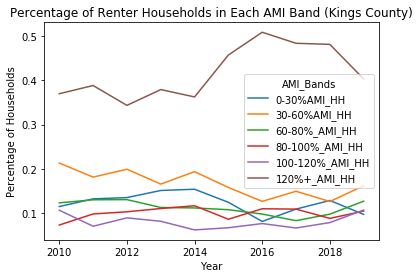

In [44]:
sns.lineplot(data=kings_melted, x="Year", y="Percentage of Households", hue="AMI_Bands",ci=None).set_title('Percentage of Renter Households in Each AMI Band (Kings County)')

Text(0.5, 1.0, 'Percentage of Renter Households in Each AMI Band (Los Angeles)')

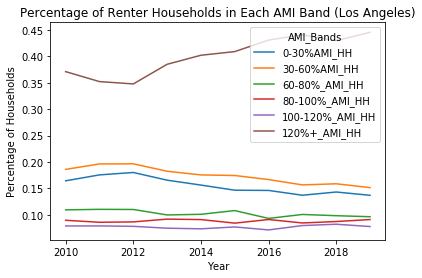

In [45]:
sns.lineplot(data=LA_melted, x="Year", y="Percentage of Households", hue="AMI_Bands",ci=None).set_title('Percentage of Renter Households in Each AMI Band (Los Angeles)')

Text(0.5, 1.0, 'Percentage of Renter Households in Each AMI Band (Fresno)')

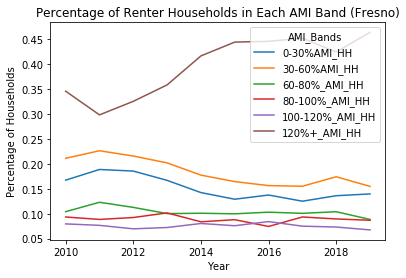

In [46]:
sns.lineplot(data=fresno_melted, x="Year", y="Percentage of Households", hue="AMI_Bands",ci=None).set_title('Percentage of Renter Households in Each AMI Band (Fresno)')

### Graph changes in changes in percentage of middle income housing over time 

In [47]:
middle_diff = pd.merge(msa, df_merged[df_merged.year.isin([2010, 2019])], on='County_Name').groupby(['year', 'MSA_NAME']).middle_income_HH.mean().reset_index()

In [48]:
middle_diff["MSA"] = middle_diff.MSA_NAME.apply(lambda x: x.split('-')[0])

Text(0.5, 1.0, 'Change in Percentage of Renter Households between 80-120% AMI between 2010 and 2019')

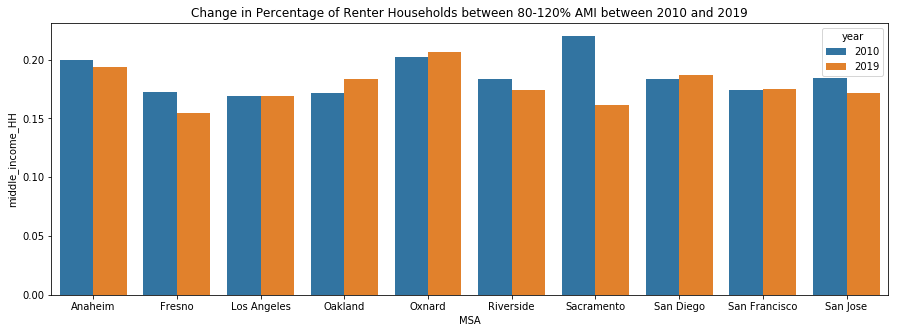

In [49]:
plt.figure(figsize=(15,5))
sns.barplot(x='MSA', y='middle_income_HH', hue='year', data=middle_diff).set_title("Change in Percentage of Renter Households between 80-120% AMI between 2010 and 2019")

### Gross rent groupings - All california 

In [50]:
# this is for all california; also want to do this for all msas 
gross_rent = df_merged[["year","gross_rent"]]
#cpi.update() #run me to make sure cpi is up to date 
def cpi_adjust_2010(x):
    return cpi.inflate(x, 2010)
gross_rent_2010 = gross_rent[gross_rent.year==2010].dropna()
gross_rent_2019 = gross_rent[gross_rent.year==2019].dropna()

#need to inflate value of 2010 
gross_rent_2010["gross_rent"] = gross_rent_2010.gross_rent.apply(lambda x: cpi_adjust_2010(x))
#put data back in one dataframe 
gross_rent = pd.concat([gross_rent_2010,gross_rent_2019])
gross_rent = gross_rent.dropna()
gross_rent.gross_rent = gross_rent.gross_rent.astype(float) #make float 

In [51]:
def rent_buckets(x):
    if x < 1000:
        return "Under \$1,000"
    if ((x>=1000)&(x<=1249)):
        return "\$1,000 - \$1,249"
    if ((x>=1250)&(x<=1499)):
        return "\$1,250 - \$1,499"
    if ((x>=1500)&(x<=1999)):
        return "\$1,500 - \$1,999"
    if x>=2000:
        return "\$2,000 or more"

In [52]:
gross_rent["Gross Rent Buckets"] = gross_rent.gross_rent.apply(lambda x: rent_buckets(x))#label buckets 
#groupby buckets and get count of amount in each bucket 
grouped_rent = gross_rent.groupby(["year","Gross Rent Buckets"]).count().reset_index().rename(columns={"gross_rent":"Count"})

In [53]:
#seperate dataframes again 
grouped_rent_2010 = grouped_rent[grouped_rent.year == 2010]
grouped_rent_2019 = grouped_rent[grouped_rent.year == 2019]
#get total values for each year so we can make proportions 
total_counts = gross_rent.groupby("year").count().reset_index() 
total_2010 = total_counts["gross_rent"][0]
total_2019 = total_counts["gross_rent"][1]

In [54]:
grouped_rent_2010["Percentage of total units"] = grouped_rent_2010["Count"] / total_2010
grouped_rent_2019["Percentage of total units"] = grouped_rent_2019["Count"] / total_2019

In [55]:
full_gross_rent = pd.concat([grouped_rent_2010,grouped_rent_2019]) #bring data back together
#pivot 
full_gross_rent_pivot = full_gross_rent.pivot(index="year", columns="Gross Rent Buckets", values="Percentage of total units").reset_index()

In [56]:
#calculate difference between years 
full_gross_rent_pivot.loc['Percentage Change from 2010 to 2019'] = ((full_gross_rent_pivot.loc[1] - full_gross_rent_pivot.loc[0])/full_gross_rent_pivot.loc[0])*100

In [58]:
cali_difference = pd.DataFrame(full_gross_rent_pivot.loc["Percentage Change from 2010 to 2019"].reset_index())
cali_difference = cali_difference[1:]

Text(0.5, 1.0, 'Percentage Change in Units Rented from 2010 to 2019 in California ($2019)')

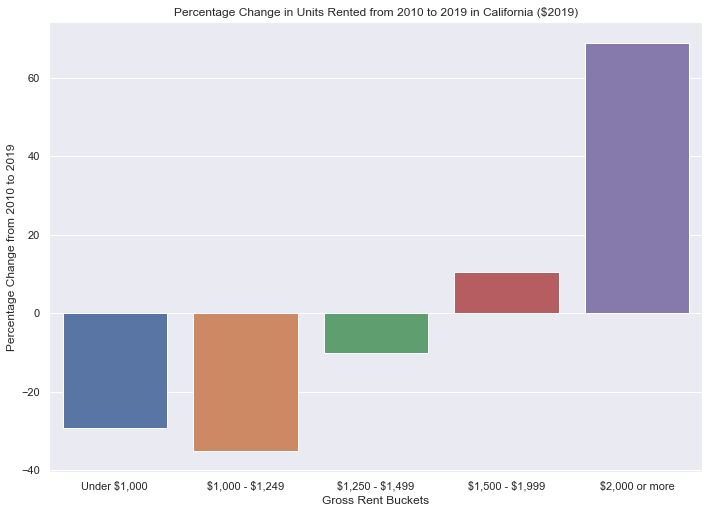

In [59]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.barplot(x="Gross Rent Buckets", y="Percentage Change from 2010 to 2019", data=cali_difference).set_title("Percentage Change in Units Rented from 2010 to 2019 in California ($2019)")

### Gross rent groupings - top 10 MSAs 

Text(0.5, 1.0, 'Percentage Change in Units Rented from 2010 to 2019 for Top 10 MSAs in CA ($2019)')

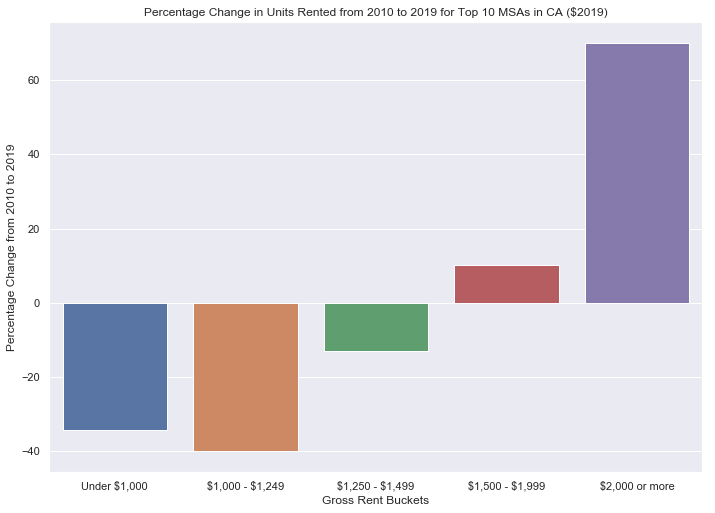

In [60]:
#have top 10 msa's merged here, need to propogate these below 
top10_msa = msa.merge(df_merged,on ="County_Name",how="left")
# this is for top 10 msas  
gross_rent_10MSA = top10_msa[["year","gross_rent"]]
gross_rent_2010_10MSA = gross_rent_10MSA[gross_rent_10MSA.year==2010].dropna()
gross_rent_2019_10MSA = gross_rent_10MSA[gross_rent_10MSA.year==2019].dropna()
#need to inflate value of 2010 
gross_rent_2010_10MSA["gross_rent"] = gross_rent_2010_10MSA.gross_rent.apply(lambda x: cpi_adjust_2010(x))
#put data back in one dataframe 
gross_rent_10MSA = pd.concat([gross_rent_2010_10MSA,gross_rent_2019_10MSA])
gross_rent_10MSA = gross_rent_10MSA.dropna()
gross_rent_10MSA.gross_rent = gross_rent_10MSA.gross_rent.astype(float) #make float 
#label buckets 
gross_rent_10MSA["Gross Rent Buckets"] = gross_rent_10MSA.gross_rent.apply(lambda x: rent_buckets(x))
#groupby buckets and get count of amount in each bucket 
grouped_rent_10MSA = gross_rent_10MSA.groupby(["year","Gross Rent Buckets"]).count().reset_index().rename(columns={"gross_rent":"Count"})
#seperate dataframes again 
grouped_rent_2010_10MSA = grouped_rent_10MSA[grouped_rent_10MSA.year == 2010]
grouped_rent_2019_10MSA = grouped_rent_10MSA[grouped_rent_10MSA.year == 2019]
#get total values for each year so we can make proportions 
total_counts_10msa = gross_rent_10MSA.groupby("year").count().reset_index() 
total_2010_10MSA = total_counts_10msa["gross_rent"][0]
total_2019_10MSA = total_counts_10msa["gross_rent"][1]
grouped_rent_2010_10MSA["Percentage of total units"] = grouped_rent_2010_10MSA["Count"] / total_2010_10MSA
grouped_rent_2019_10MSA["Percentage of total units"] = grouped_rent_2019_10MSA["Count"] / total_2019_10MSA

full_gross_rent_10MSA = pd.concat([grouped_rent_2010_10MSA,grouped_rent_2019_10MSA]) #bring data back together
#pivot 
full_gross_rent_pivot_10MSA = full_gross_rent_10MSA.pivot(index="year", columns="Gross Rent Buckets", values="Percentage of total units").reset_index()

#calculate difference between years 
full_gross_rent_pivot_10MSA.loc['Percentage Change from 2010 to 2019'] = ((full_gross_rent_pivot_10MSA.loc[1] - full_gross_rent_pivot_10MSA.loc[0])/full_gross_rent_pivot_10MSA.loc[0])*100
#make a pivot table adn only keep row that shows the percent difference calculation 
top10MSA_difference_ = pd.DataFrame(full_gross_rent_pivot_10MSA.loc["Percentage Change from 2010 to 2019"].reset_index())
top10MSA_difference = top10MSA_difference_[1:]
#graph 
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.barplot(x="Gross Rent Buckets", y="Percentage Change from 2010 to 2019", data=top10MSA_difference).set_title("Percentage Change in Units Rented from 2010 to 2019 for Top 10 MSAs in CA ($2019)")